In [1]:
import numpy as np 
import xarray as xr 
import matplotlib.pyplot as plt 
import observefunc as obs

# Analyse NCDF

In [2]:
#folder= "/home/peter/EasterIslands/Code/Full_Model/#Figs/FullModel_grid50_repr0,07_06Apr/"
#folder = "/home/peter/EasterIslands/Code/Full_Model/Figs/FullModel_grid50_repr0,007_Standard/"
folder = "/home/peter/EasterIslands/Code/Full_Model/Figs/FullModel_grid50_repr7e-03_mv8_Standard/"
folder="/home/peter/EasterIslands/Code/Full_Model/Figs/Test/FullModel_grid20_repr3e-02_mv8_Standard/"#/Statistics.ncdf
folder="/home/peter/EasterIslands/Code/Full_Model/Figs_WithDrought/FullModel_grid50_repr7e-03_mv10_Standard/"#Statistics.ncdf"
folder= "/home/peter/EasterIslands/Code/Full_Model/RunsMay10_KTH/FullModel_grid80_repr7e-03_mv100_withRegrowth_lowFix_seed101/"

In [3]:
data = xr.open_dataset(folder+"Statistics.ncdf")
#data

In [4]:
obs.plot_statistics(data, folder)

(<Figure size 720x432 with 3 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f405bf4cd68>)

# MAP

In [5]:
import pickle
import config
from pathlib import Path   # for creating a new directory
filename = "Map/EI_grid"+str(data.gridpoints_y)+"_rad"+str(data.tree_search_radius)+"+"+str(data.agriculture_radius)+"+"+str(data.moving_radius_later)
if Path(filename).is_file():
    with open(filename, "rb") as EIfile:
        config.EI = pickle.load(EIfile)


In [6]:
obs.observe(1900, fig=None, ax=None, specific_ag_to_follow=None, save=True, data = data, ncdf=True, folder=folder)

(<Figure size 720x432 with 3 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fd557ed6588>)

index
305    0.236380
306    0.229333
308    0.292767
309    0.630205
310    0.533002
311    0.242789
312    0.287931
313    0.338083
314    0.353619
315    0.202270
316    0.307310
317    0.688892
318    0.308658
319    0.685261
320    0.650512
321    0.627323
322    0.327418
323    0.392002
324    0.693963
325    0.691432
326    0.204181
327    0.213405
328    0.660889
329    0.695487
330    0.213453
331    0.694777
332    0.202951
333    0.212240
334    0.204504
335    0.203335
         ...   
365    0.435436
366    0.582915
367    0.378900
368    0.668957
369    0.608251
370    0.674714
371    0.505533
372    0.237554
374    0.310524
375    0.764155
376    0.312925
377    0.465061
379    0.225531
380    0.688080
382    0.798680
384    0.358860
385    0.456882
386    0.580005
387    0.691856
388    0.217992
390    0.619098
391    0.432632
392    0.675842
393    0.799299
394    0.494257
399    0.706904
400    0.278125
401    0.386459
404    0.799194
407    0.716974
Name: TreePrefAgen

array([ True, False, False, False, False, False, False, False, False,
       False, False, False])

array([ 800,  800,  800, ..., 1855, 1855, 1856])

In [7]:
def plot_fires_loc(data,folder):
    face_colors =data.tree_density.sel(time=800)*0
    time_arr = np.arange(800, 1901, step=100)
    for loc, size,time in zip(data.firesLoc, data.firesSize, data.firesTime):
        slot = np.where(time_arr<=time)[0][0]
        face_colors[loc] +=size
    fig = plt.figure(figsize=(10,6))
    ax = fig.add_subplot(111,fc="lightgray")
    firePlot = ax.tripcolor(config.EI.points_EI_km[:,0], config.EI.corners['upper_left'][1] - config.EI.points_EI_km[:,1], 
    config.EI.EI_triangles, facecolors=face_colors, vmin = 0, vmax = np.max(face_colors), cmap="Reds", alpha=1)

    watertriangles = np.zeros([config.EI.N_els])
    watertriangles[config.EI.water_triangle_inds]=1
    #watercmap =  LinearSegmentedColormap.from_list("watercmap",[(0,0,0,0),(127/255,1,212/255 ,1 )],N=2) # AQUAMARINE
    watercmap =  LinearSegmentedColormap.from_list("watercmap",[(0,0,0,0),(3/255,169/255,244/255 ,1 )],N=2) # Indigo blue
    _ = ax.tripcolor(config.EI.points_EI_km[:,0], config.EI.corners['upper_left'][1] - config.EI.points_EI_km[:,1], 
    config.EI.EI_triangles, facecolors=watertriangles, vmin = 0, vmax = 1, cmap=watercmap, alpha=None) 

    #for i in config.EI.water_midpoints:
    #    ax.plot([i[0]], [config.EI.corners['upper_left'][1]- i[1]], 'o',markersize=5, color="blue")
    
    ax.set_aspect('equal')
    divider = make_axes_locatable(plt.gca())
    if save:
        cax = divider.append_axes("right", "5%", pad="3%")
        cb1 = colorbar(treePlot, cax =cax) 
        cb1.set_label_text("Burnt trees in Triangle")
    return fig, ax, divider, firePlot

In [8]:
plot_fires_loc(data,folder)

NameError: name 'LinearSegmentedColormap' is not defined

In [8]:
def get_fires_in_t(t_0, t_1):
    fires_points=[]
    n=0
    while data.firesTime[n]<t_0:
        n+=1
    while data.firesTime[n]<t_1 and data.firesTime[n]>=t_0:
    #inds = np.where(data.firesTime==t)[0]
    #for n in inds:
        loc = config.EI.EI_midpoints[int(data.firesLoc[n])]
        fires_points.append([loc[0], loc[1], data.firesSize[n]])
        n+=1
    fires_points=np.array(fires_points)
    return fires_points


In [14]:
fires_points = get_fires_in_t(1100,1200)

(array([3., 2., 0., 1., 3., 2., 4., 4., 3., 5.]),
 array([ 64. , 103.9, 143.8, 183.7, 223.6, 263.5, 303.4, 343.3, 383.2,
        423.1, 463. ]),
 <a list of 10 Patch objects>)

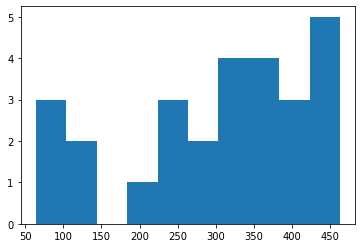

In [15]:
plt.hist(fires_points[:,2])

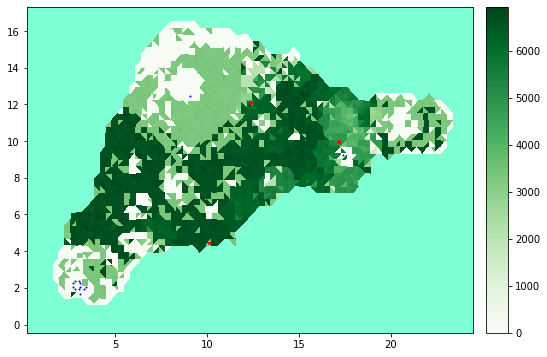

In [16]:
times_to_plot = np.arange(1200,1210,step=10)
for t in times_to_plot:
    fires_points = get_fires_in_t(t-10, t)
    config.EI.tree_density = data.tree_density.sel(time=t)
    fig, ax = config.EI.plot_TreeMap_and_hist()
    
    plot = ax.scatter(fires_points[:,0], config.EI.corners['upper_left'][1] - fires_points[:,1], s=10*fires_points[:,2]/max(fires_points[:,2]), color='red')


In [ ]:
times_to_plot = np.arange(1200,1210,step=10)

times_to_plot

In [45]:
fires_points

array([[ 15.79083688,   4.18971373, 229.        ],
       [ 15.79083688,   4.18971373, 228.        ],
       [ 15.79083688,   4.18971373, 213.        ],
       ...,
       [  5.33474219,  11.25237403, 127.        ],
       [  3.62762469,  11.97061067, 317.        ],
       [  3.73431953,  12.32972899, 381.        ]])

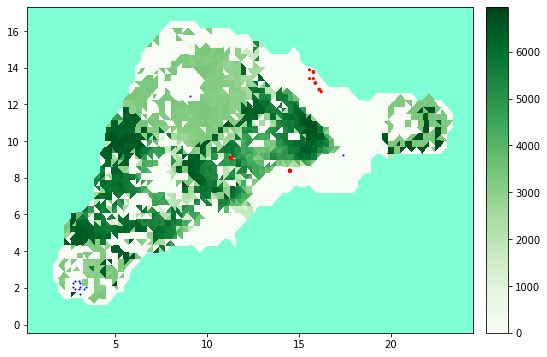

In [56]:
fires_points[:,2]/max(fires_points[:,2])

array([0.48516949, 0.48305085, 0.45127119, 0.48305085, 0.47033898,
       0.40466102, 0.79025424, 0.81144068, 1.        , 1.        ,
       1.        , 1.        , 0.09957627, 0.39830508, 0.40677966,
       0.9809322 , 0.99576271, 0.4279661 ])

# CHECK KTH RUNS


In [7]:
folder = "/home/peter/EasterIslands/Code/Full_Model/KTHruns/FullModel_grid50_repr7e-03_mv12_Standard_seed31/"
file = folder+"Statistics.ncdf"
data = xr.open_dataset(file)

In [9]:
obs.plot_statistics(data, folder)

In [10]:
data

<xarray.Dataset>
Dimensions:              (2d: 2, index: 2554, time: 1101, triangles: 2768)
Coordinates:
  * index                (index) int64 0 1 2 3 4 5 ... 2549 2550 2551 2552 2553
  * triangles            (triangles) int64 0 1 2 3 4 ... 2764 2765 2766 2767
  * 2d                   (2d) object 'x' 'y'
  * time                 (time) int64 800 801 802 803 ... 1897 1898 1899 1900
Data variables:
    Penalty_Std          (time) float64 ...
    Fraction_eroded      (time) float64 ...
    FishersPop           (time) float64 ...
    tree_density         (triangles, time) float64 ...
    Penalty_Mean         (time) float64 ...
    SizeAgents           (index, time) float64 ...
    total_deaths         (time) int64 ...
    agriculture          (triangles, time) float64 ...
    populationOccupancy  (triangles, time) float64 ...
    total_population     (time) int64 77 77 77 78 81 ... 18086 18194 18202 17977
    total_trees          (time) int64 11999700 11999392 ... 1284691 1240731
    PosA

In [14]:
data.firesSize.min()

-6406

In [15]:
data.total_trees.sel(time=1450)

<xarray.DataArray 'total_trees' ()>
array(8460146)
Coordinates:
    time     int64 1450